In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from pytorch_forecasting import TimeSeriesDataSet
import lightning.pytorch as pl
import torch.nn.functional as F
from torchinfo import summary
from pytorch_lightning.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint, RichProgressBar
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_squared_log_error,
    median_absolute_error,
    explained_variance_score,
    r2_score,
)
from torchmetrics import (
    MeanSquaredError,
    MeanAbsoluteError,
    ExplainedVariance,
    R2Score,
)
import warnings
warnings.filterwarnings("ignore")

# config
%matplotlib inline
%config InlineBackend.figure_format='retina'

### 读取数据集


In [2]:
nsdk_data = pd.read_csv("../data/A纳斯达克综合指数.csv", index_col=0, parse_dates=True)
dqs_data = pd.read_csv("../data/A道琼斯工业平均指数.csv", index_col=0, parse_dates=True)
bzpr_data = pd.read_csv("../data/A标准普尔500指数.csv", index_col=0, parse_dates=True)
sh_data = pd.read_csv("../data/A上证指数.csv", index_col=0, parse_dates=True)
sz_data = pd.read_csv("../data/A深证指数.csv", index_col=0, parse_dates=True)
cyb_data = pd.read_csv("../data/A创业板指数.csv", index_col=0, parse_dates=True)

In [3]:
stock_market = [0, nsdk_data, dqs_data, bzpr_data, sh_data, sz_data, cyb_data]
stock_name = [
    "",
    "Nasdaq Composite Index",
    "DowJones Industrial Average Index",
    "S&P 500 Index",
    "Shanghai Composite Index",
    "Shenzhen Index",
    "ChiNext Index",
]

features_one = ["Open", "High", "Low", "Volume"]
features_two = [
    "open",
    "high",
    "low",
    "volume",
    "price_change",
    "p_change",
    "ma5",
    "ma10",
    "ma20",
    "v_ma5",
    "v_ma10",
    "v_ma20",
]

### DataModule


In [4]:
class MultivariateSeriesDataModule(pl.LightningDataModule):
    def __init__(
        self,
        data: pd.DataFrame,
        n_lags: int,
        horizon: int,
        test_size: float = 0.2,
        batch_size: int = 16,
        target_name: str = "",
    ):
        super().__init__()
        self.data = data
        self.feature_names = [col for col in data.columns if col != target_name]
        self.batch_size = batch_size
        self.test_size = test_size
        self.n_lags = n_lags
        self.horizon = horizon
        self.target_name = target_name
        self.target_scaler = MinMaxScaler()
        self.training: TimeSeriesDataSet
        self.validation: TimeSeriesDataSet
        self.test: TimeSeriesDataSet
        self.predict: TimeSeriesDataSet
        self.setup()

    def preprocess_data(self):
        self.data["target"] = self.data[self.target_name]
        self.data["time_index"] = np.arange(len(self.data))
        self.data["group_id"] = 0

    def split_data(self):
        time_indices = self.data["time_index"].values
        train_indices, test_indices = train_test_split(
            time_indices, test_size=self.test_size, shuffle=False
        )
        train_indices, val_indices = train_test_split(
            train_indices, test_size=0.1, shuffle=False
        )
        return train_indices, val_indices, test_indices

    def scale_target(self, df, indices):
        scaled_values = self.target_scaler.transform(df.loc[indices, ["target"]])
        df.loc[indices, "target"] = scaled_values

    def setup(self, stage=None):
        self.preprocess_data()
        train_indices, val_indices, test_indices = self.split_data()

        train_df = self.data.loc[self.data["time_index"].isin(train_indices)]
        val_df = self.data.loc[self.data["time_index"].isin(val_indices)]
        test_df = self.data.loc[self.data["time_index"].isin(test_indices)]
        predict_df = pd.concat([train_df, val_df, test_df])

        self.target_scaler.fit(train_df[["target"]])
        self.scale_target(train_df, train_df.index)
        self.scale_target(val_df, val_df.index)
        self.scale_target(test_df, test_df.index)

        train_df = train_df.drop(self.target_name, axis=1)
        val_df = val_df.drop(self.target_name, axis=1)
        test_df = test_df.drop(self.target_name, axis=1)

        self.training = TimeSeriesDataSet(
            train_df,
            time_idx="time_index",
            target="target",
            group_ids=["group_id"],
            max_encoder_length=self.n_lags,
            max_prediction_length=self.horizon,
            time_varying_unknown_reals=self.feature_names,
            scalers={name: MinMaxScaler() for name in self.feature_names},
        )
        self.validation = TimeSeriesDataSet.from_dataset(
            self.training, val_df, stop_randomization=True
        )
        self.test = TimeSeriesDataSet.from_dataset(
            self.training, test_df, stop_randomization=True
        )
        self.predict = TimeSeriesDataSet.from_dataset(
            self.training, predict_df, stop_randomization=True
        )

    def train_dataloader(self):
        return self.training.to_dataloader(batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return self.validation.to_dataloader(batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return self.test.to_dataloader(batch_size=self.batch_size, shuffle=False)

    def predict_dataloader(self):
        return self.predict.to_dataloader(batch_size=1, shuffle=False)

### LSTM Model


In [5]:
class MultivariateLSTM(pl.LightningModule):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, lr=0.001):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.lr = lr
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
        )
        self.fc1 = nn.Linear(in_features=hidden_dim, out_features=16)
        self.fc2 = nn.Linear(in_features=16, out_features=output_dim)

        self.mse = MeanSquaredError()
        self.mae = MeanAbsoluteError()
        self.evs = ExplainedVariance()
        self.r2 = R2Score()

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc1(out)
        out = self.fc2(out)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x["encoder_cont"])
        loss = F.mse_loss(y_pred, y[0])
        self.log("train_loss", loss)
        self.log("train_mse", self.mse(y_pred, y[0]))
        self.log("train_mae", self.mae(y_pred, y[0]))
        self.log("train_evs", self.evs(y_pred, y[0]))
        self.log("train_r2", self.r2(y_pred, y[0]))
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x["encoder_cont"])
        loss = F.mse_loss(y_pred, y[0])
        self.log("validation_loss", loss)
        self.log("validation_mse", self.mse(y_pred, y[0]))
        self.log("validation_mae", self.mae(y_pred, y[0]))
        self.log("validation_evs", self.evs(y_pred, y[0]))
        self.log("validation_r2", self.r2(y_pred, y[0]))
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x["encoder_cont"])
        loss = F.mse_loss(y_pred, y[0])
        self.log("test_loss", loss)
        self.log("test_mse", self.mse(y_pred, y[0]))
        self.log("test_mae", self.mae(y_pred, y[0]))
        self.log("test_evs", self.evs(y_pred, y[0]))
        self.log("test_r2", self.r2(y_pred, y[0]))
        return loss

    def predict_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x["encoder_cont"])
        y_pred = y_pred.detach().numpy()
        y_pred = self.trainer.datamodule.target_scaler.inverse_transform(y_pred)
        return y_pred

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

### CNN Model


In [6]:
class CNNModel(pl.LightningModule):
    def __init__(
        self,
        num_features: int,
        output_dim: int,
        hidden_dim,
        num_layers,
        lr: float = 0.001,
    ):
        super().__init__()
        self.lr = lr
        self.conv1d = nn.Conv1d(
            in_channels=num_features, out_channels=32, kernel_size=3
        )
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=3)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(
            32 * ((num_features - 2) // 4), 64
        )  # 计算一维卷积和池化后的大小
        self.fc2 = nn.Linear(64, output_dim)

        self.mse = MeanSquaredError()
        self.mae = MeanAbsoluteError()
        self.evs = ExplainedVariance()
        self.r2 = R2Score()

    def forward(self, x):
        x = self.conv1d(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x["encoder_cont"].permute(0, 2, 1))
        loss = F.mse_loss(y_pred, y[0])
        self.log("train_loss", loss)
        self.log("train_mse", self.mse(y_pred, y[0]))
        self.log("train_mae", self.mae(y_pred, y[0]))
        self.log("train_evs", self.evs(y_pred, y[0]))
        self.log("train_r2", self.r2(y_pred, y[0]))
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x["encoder_cont"].permute(0, 2, 1))
        loss = F.mse_loss(y_pred, y[0])
        self.log("validation_loss", loss)
        self.log("validation_mse", self.mse(y_pred, y[0]))
        self.log("validation_mae", self.mae(y_pred, y[0]))
        self.log("validation_evs", self.evs(y_pred, y[0]))
        self.log("validation_r2", self.r2(y_pred, y[0]))
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x["encoder_cont"].permute(0, 2, 1))
        loss = F.mse_loss(y_pred, y[0])
        self.log("test_loss", loss)
        self.log("test_mse", self.mse(y_pred, y[0]))
        self.log("test_mae", self.mae(y_pred, y[0]))
        self.log("test_evs", self.evs(y_pred, y[0]))
        self.log("test_r2", self.r2(y_pred, y[0]))
        return loss

    def predict_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x["encoder_cont"].permute(0, 2, 1))
        y_pred = y_pred.detach().numpy()
        y_pred = self.trainer.datamodule.target_scaler.inverse_transform(y_pred)
        return y_pred

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

### SVR 模型，回归


                     Metric   Value
0        Mean Squared Error  150.17
1       Mean Absolute Error    8.80
2     Median Absolute Error    6.15
3  Explained Variance Score    1.00
4                  R2 Score    1.00


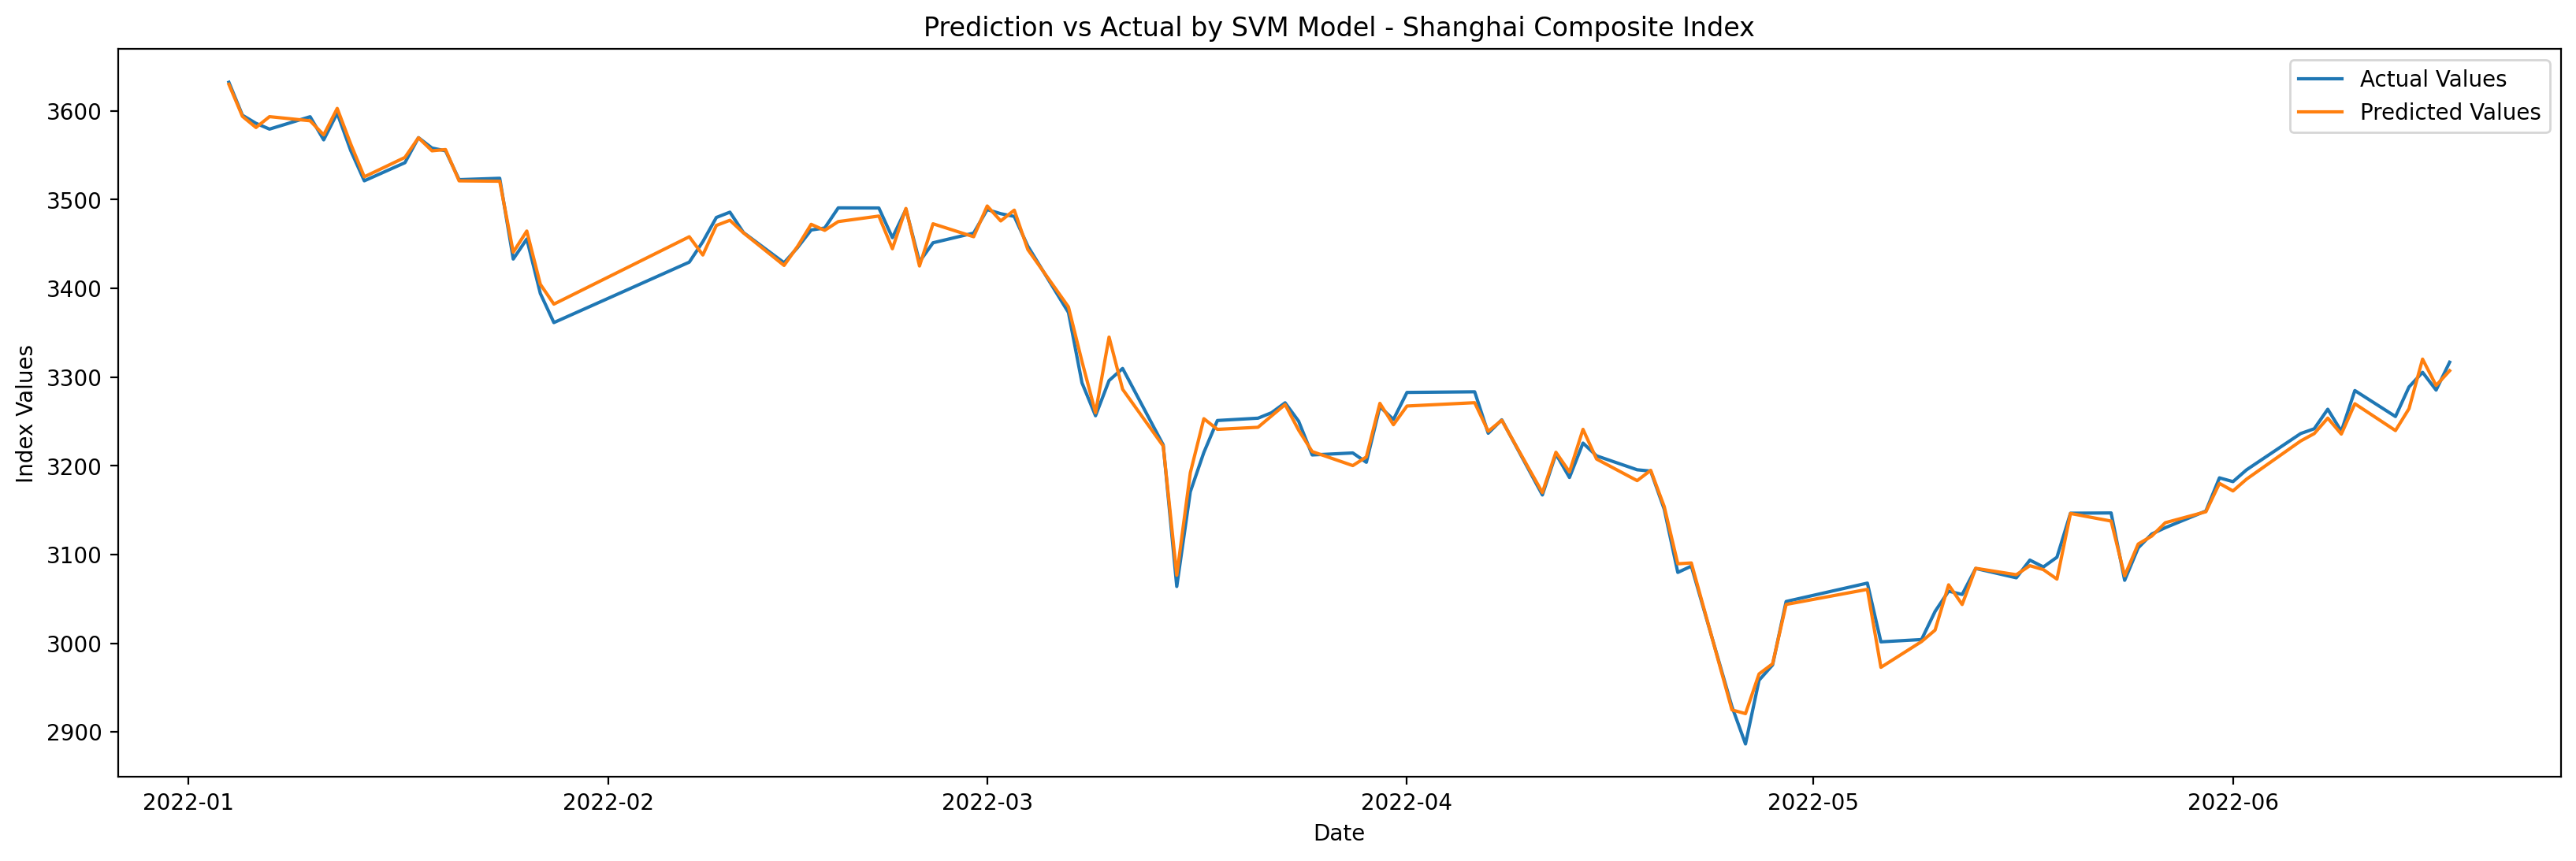

In [165]:
stock_index = 4
data = stock_market[stock_index]
X, y = data[features_two], data["close"]

# 将数据集分成前70%作为训练集，后30%作为测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=False
)
# 特征标准化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# 构建SVR模型
svr = SVR(kernel="linear")
svr.fit(X_train, y_train)
# 预测
y_pred = svr.predict(X_test)
# 评估模型
# 计算均方误差（MSE）
mse = mean_squared_error(y_test, y_pred)
# 平均绝对误差（MAE）
mae = mean_absolute_error(y_test, y_pred)
# 均方对数误差 (MSLE)
msle = mean_squared_log_error(y_test, y_pred)
# 中值绝对误差 (MedAE)
medae = median_absolute_error(y_test, y_pred)
# 解释方差分数
evs = explained_variance_score(y_test, y_pred)
# R2 分数（决定系数）
R2 = r2_score(y_test, y_pred)

# 将指标存储在字典中
metrics = {
    "Mean Squared Error": mse,
    "Mean Absolute Error": mae,
    "Median Absolute Error": medae,
    "Explained Variance Score": evs,
    "R2 Score": R2,
}

# 创建一个DataFrame
df_metrics = pd.DataFrame(list(metrics.items()), columns=["Metric", "Value"])
df_metrics["Value"] = df_metrics["Value"].round(2)
# 显示DataFrame
print(df_metrics)

# 可视化预测结果和实际数据
plt.figure(figsize=(20, 6))
plt.plot(y_test.index, y_test, label="Actual Values")
plt.plot(y_test.index, y_pred, label="Predicted Values")
plt.xlabel("Date")
plt.ylabel("Index Values")
plt.title("Prediction vs Actual" + " by SVM Model - " + stock_name[stock_index])
plt.legend()
plt.show()

### 道琼斯指数


#### 检查数据集


In [20]:
stock_index = 2
data = stock_market[stock_index]

datamodule = MultivariateSeriesDataModule(
    data=data[features_one + ["Close"]],
    n_lags=10,
    horizon=1,
    test_size=0.2,
    target_name="Close",
    batch_size=16,
)

train_dataloader = datamodule.train_dataloader()
x, y = next(iter(train_dataloader))
# print("x =", x)
# print("\ny =", y)
print("\nsizes of x =")
for key, value in x.items():
    print(f"\t{key} = {value.size()}")


sizes of x =
	encoder_cat = torch.Size([16, 10, 0])
	encoder_cont = torch.Size([16, 10, 4])
	encoder_target = torch.Size([16, 10])
	encoder_lengths = torch.Size([16])
	decoder_cat = torch.Size([16, 1, 0])
	decoder_cont = torch.Size([16, 1, 4])
	decoder_target = torch.Size([16, 1])
	decoder_lengths = torch.Size([16])
	decoder_time_idx = torch.Size([16, 1])
	groups = torch.Size([16, 1])
	target_scale = torch.Size([16, 2])


#### 检查模型


In [32]:
model = MultivariateLSTM(
    input_dim=len(features_one), hidden_dim=64, num_layers=2, output_dim=1, lr=0.001
)
summary(model, input_size=(16, 10, len(features_one)))

Layer (type:depth-idx)                   Output Shape              Param #
MultivariateLSTM                         [16, 1]                   --
├─LSTM: 1-1                              [16, 10, 64]              51,200
├─Linear: 1-2                            [16, 16]                  1,040
├─Linear: 1-3                            [16, 1]                   17
Total params: 52,257
Trainable params: 52,257
Non-trainable params: 0
Total mult-adds (M): 8.21
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.21
Estimated Total Size (MB): 0.30

In [22]:
logger = TensorBoardLogger("lightning_logs", name="downjones")
# early_stop_callback = EarlyStopping(
#     monitor="validation_loss", min_delta=1e-4, patience=10, verbose=False, mode="min"
# )
# model_checkpoint = ModelCheckpoint(
#     dirpath="checkpoints/downjones",
#     filename="{epoch}-{val_loss:.2f}-{other_metric:.2f}",
# )
rich_progress_bar = RichProgressBar()
trainer = pl.Trainer(
    logger=logger,
    # callbacks=[model_checkpoint, early_stop_callback, rich_progress_bar],
    callbacks=[rich_progress_bar],
    max_epochs=500,
    accelerator="cpu",
)
trainer.fit(model=model, datamodule=datamodule)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


┏━━━┳━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name ┃ Type              ┃ Params ┃
┡━━━╇━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ lstm │ LSTM              │ 51.2 K │
│ 1 │ fc1  │ Linear            │  1.0 K │
│ 2 │ fc2  │ Linear            │     17 │
│ 3 │ mse  │ MeanSquaredError  │      0 │
│ 4 │ mae  │ MeanAbsoluteError │      0 │
│ 5 │ evs  │ ExplainedVariance │      0 │
│ 6 │ r2   │ R2Score           │      0 │
└───┴──────┴───────────────────┴────────┘

Trainable params: 52.3 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 52.3 K                                                                                               
Total estimated model params size (MB): 0

Output()

`Trainer.fit` stopped: `max_epochs=500` reached.


In [23]:
trainer.test(model=model, datamodule=datamodule)

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_evs          │    -0.6729999780654907    │
│         test_loss         │   0.0017951647751033306   │
│         test_mae          │    0.03245149925351143    │
│         test_mse          │   0.0017951647751033306   │
│          test_r2          │    -0.772804319858551     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.0017951647751033306,
  'test_mse': 0.0017951647751033306,
  'test_mae': 0.03245149925351143,
  'test_evs': -0.6729999780654907,
  'test_r2': -0.772804319858551}]

In [24]:
trainer.validate(model=model, datamodule=datamodule)

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      validation_evs       │    0.42281877994537354    │
│      validation_loss      │   0.0020633030217140913   │
│      validation_mae       │    0.03720683604478836    │
│      validation_mse       │   0.0020633030217140913   │
│       validation_r2       │    0.3937675356864929     │
└───────────────────────────┴───────────────────────────┘

[{'validation_loss': 0.0020633030217140913,
  'validation_mse': 0.0020633030217140913,
  'validation_mae': 0.03720683604478836,
  'validation_evs': 0.42281877994537354,
  'validation_r2': 0.3937675356864929}]

In [25]:
prediction = trainer.predict(model=model, datamodule=datamodule)

Output()

In [26]:
prediction = np.concatenate(prediction)
prediction = prediction.flatten()

In [27]:
actual_final = data["Close"].values[-len(prediction) :]

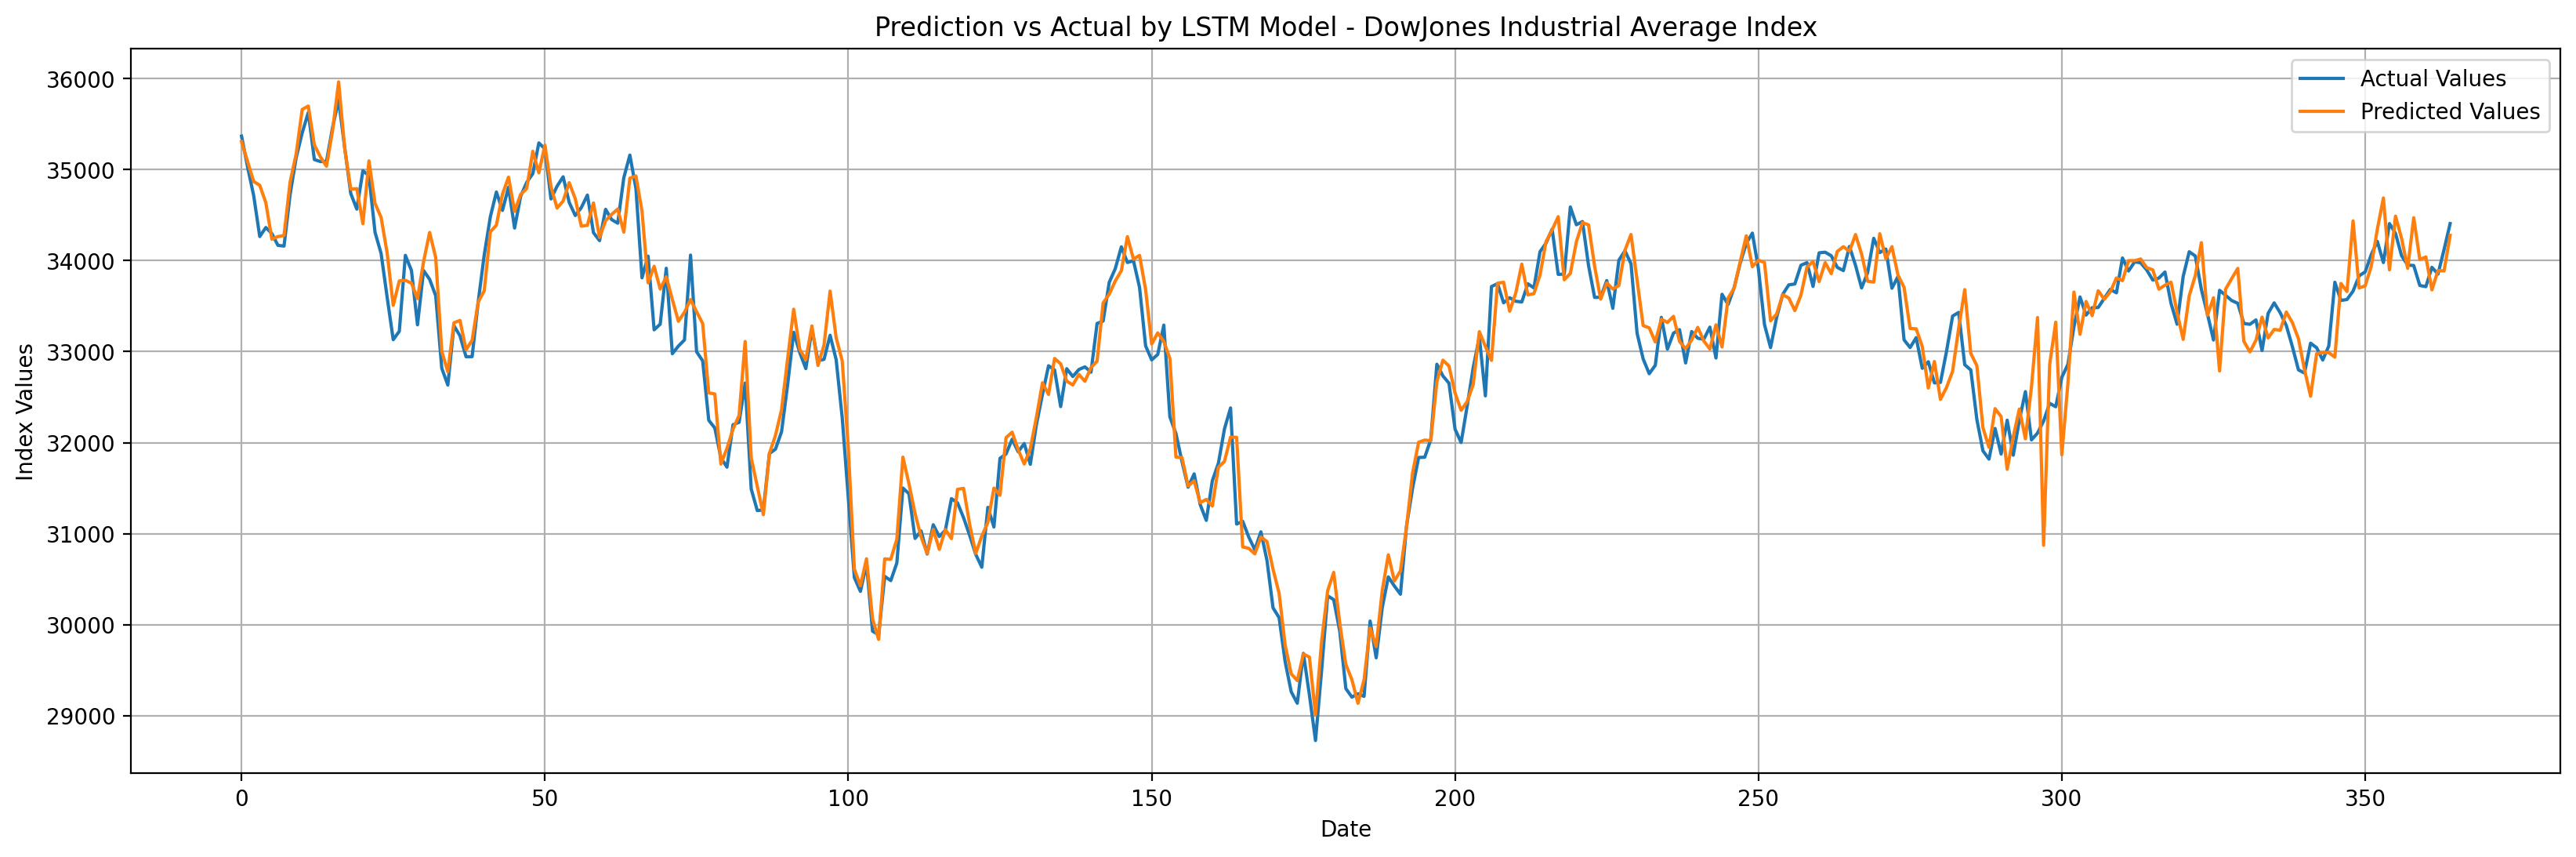

In [28]:
temp = pd.DataFrame(zip(prediction, actual_final), columns=["y_pred", "test"])
# 可视化预测结果和实际数据
plt.figure(figsize=(20, 6))
plt.plot(temp.index, temp["test"], label="Actual Values")
plt.plot(temp.index, temp["y_pred"], label="Predicted Values")
plt.xlabel("Date")
plt.ylabel("Index Values")
plt.title("Prediction vs Actual" + " by LSTM Model - " + stock_name[stock_index])
plt.legend()
plt.grid()
plt.show()

### 上证指数


#### 检查数据集


In [7]:
stock_index = 4
data = stock_market[stock_index]

datamodule = MultivariateSeriesDataModule(
    data=data[features_two + ["close"]],
    n_lags=10,
    horizon=1,
    test_size=0.2,
    target_name="close",
    batch_size=16,
)

train_dataloader = datamodule.train_dataloader()
x, y = next(iter(train_dataloader))
# print("x =", x)
# print("\ny =", y)
print("\nsizes of x =")
for key, value in x.items():
    print(f"\t{key} = {value.size()}")


sizes of x =
	encoder_cat = torch.Size([16, 10, 0])
	encoder_cont = torch.Size([16, 10, 12])
	encoder_target = torch.Size([16, 10])
	encoder_lengths = torch.Size([16])
	decoder_cat = torch.Size([16, 1, 0])
	decoder_cont = torch.Size([16, 1, 12])
	decoder_target = torch.Size([16, 1])
	decoder_lengths = torch.Size([16])
	decoder_time_idx = torch.Size([16, 1])
	groups = torch.Size([16, 1])
	target_scale = torch.Size([16, 2])


#### 检查模型


In [8]:
model = CNNModel(
    num_features=len(features_two), hidden_dim=64, num_layers=1, output_dim=1, lr=0.001
)
# model
summary(model, input_size=(16, len(features_two), 10))

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [16, 1]                   --
├─Conv1d: 1-1                            [16, 32, 8]               1,184
├─ReLU: 1-2                              [16, 32, 8]               --
├─MaxPool1d: 1-3                         [16, 32, 2]               --
├─Flatten: 1-4                           [16, 64]                  --
├─Linear: 1-5                            [16, 64]                  4,160
├─ReLU: 1-6                              [16, 64]                  --
├─Linear: 1-7                            [16, 1]                   65
Total params: 5,409
Trainable params: 5,409
Non-trainable params: 0
Total mult-adds (M): 0.22
Input size (MB): 0.01
Forward/backward pass size (MB): 0.04
Params size (MB): 0.02
Estimated Total Size (MB): 0.07

In [9]:
logger = TensorBoardLogger("lightning_logs", name="Shanghai-Composite-Index")
# early_stop_callback = EarlyStopping(
#     monitor="validation_loss", min_delta=1e-4, patience=10, verbose=False, mode="min"
# )
# model_checkpoint = ModelCheckpoint(
#     dirpath="checkpoints/downjones",
#     filename="{epoch}-{val_loss:.2f}-{other_metric:.2f}",
# )
rich_progress_bar = RichProgressBar()
trainer = pl.Trainer(
    logger=logger,
    # callbacks=[model_checkpoint, early_stop_callback, rich_progress_bar],
    callbacks=[rich_progress_bar],
    max_epochs=500,
    accelerator="cpu",
)
trainer.fit(model=model, datamodule=datamodule)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ conv1d  │ Conv1d            │  1.2 K │
│ 1 │ relu    │ ReLU              │      0 │
│ 2 │ maxpool │ MaxPool1d         │      0 │
│ 3 │ flatten │ Flatten           │      0 │
│ 4 │ fc1     │ Linear            │  4.2 K │
│ 5 │ fc2     │ Linear            │     65 │
│ 6 │ mse     │ MeanSquaredError  │      0 │
│ 7 │ mae     │ MeanAbsoluteError │      0 │
│ 8 │ evs     │ ExplainedVariance │      0 │
│ 9 │ r2      │ R2Score           │      0 │
└───┴─────────┴───────────────────┴────────┘

Trainable params: 5.4 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 5.4 K                                                                                                
Total estimated model params size (MB): 0

Output()

`Trainer.fit` stopped: `max_epochs=500` reached.


In [10]:
trainer.test(model, datamodule=datamodule)

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_evs          │    0.3779846131801605     │
│         test_loss         │   0.0050258636474609375   │
│         test_mae          │    0.0544910728931427     │
│         test_mse          │   0.0050258636474609375   │
│          test_r2          │    0.36221471428871155    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.0050258636474609375,
  'test_mse': 0.0050258636474609375,
  'test_mae': 0.0544910728931427,
  'test_evs': 0.3779846131801605,
  'test_r2': 0.36221471428871155}]

In [11]:
trainer.validate(model=model, datamodule=datamodule)

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      validation_evs       │    0.28606659173965454    │
│      validation_loss      │    0.00983817595988512    │
│      validation_mae       │    0.08031420409679413    │
│      validation_mse       │    0.00983817595988512    │
│       validation_r2       │   -0.26167619228363037    │
└───────────────────────────┴───────────────────────────┘

[{'validation_loss': 0.00983817595988512,
  'validation_mse': 0.00983817595988512,
  'validation_mae': 0.08031420409679413,
  'validation_evs': 0.28606659173965454,
  'validation_r2': -0.26167619228363037}]

In [12]:
prediction = trainer.predict(model=model, datamodule=datamodule)

Output()

In [13]:
scaler = datamodule.target_scaler

In [14]:
prediction = np.concatenate(prediction)
prediction = prediction.flatten()

In [15]:
actual_final = data["close"].values[-len(prediction) :]

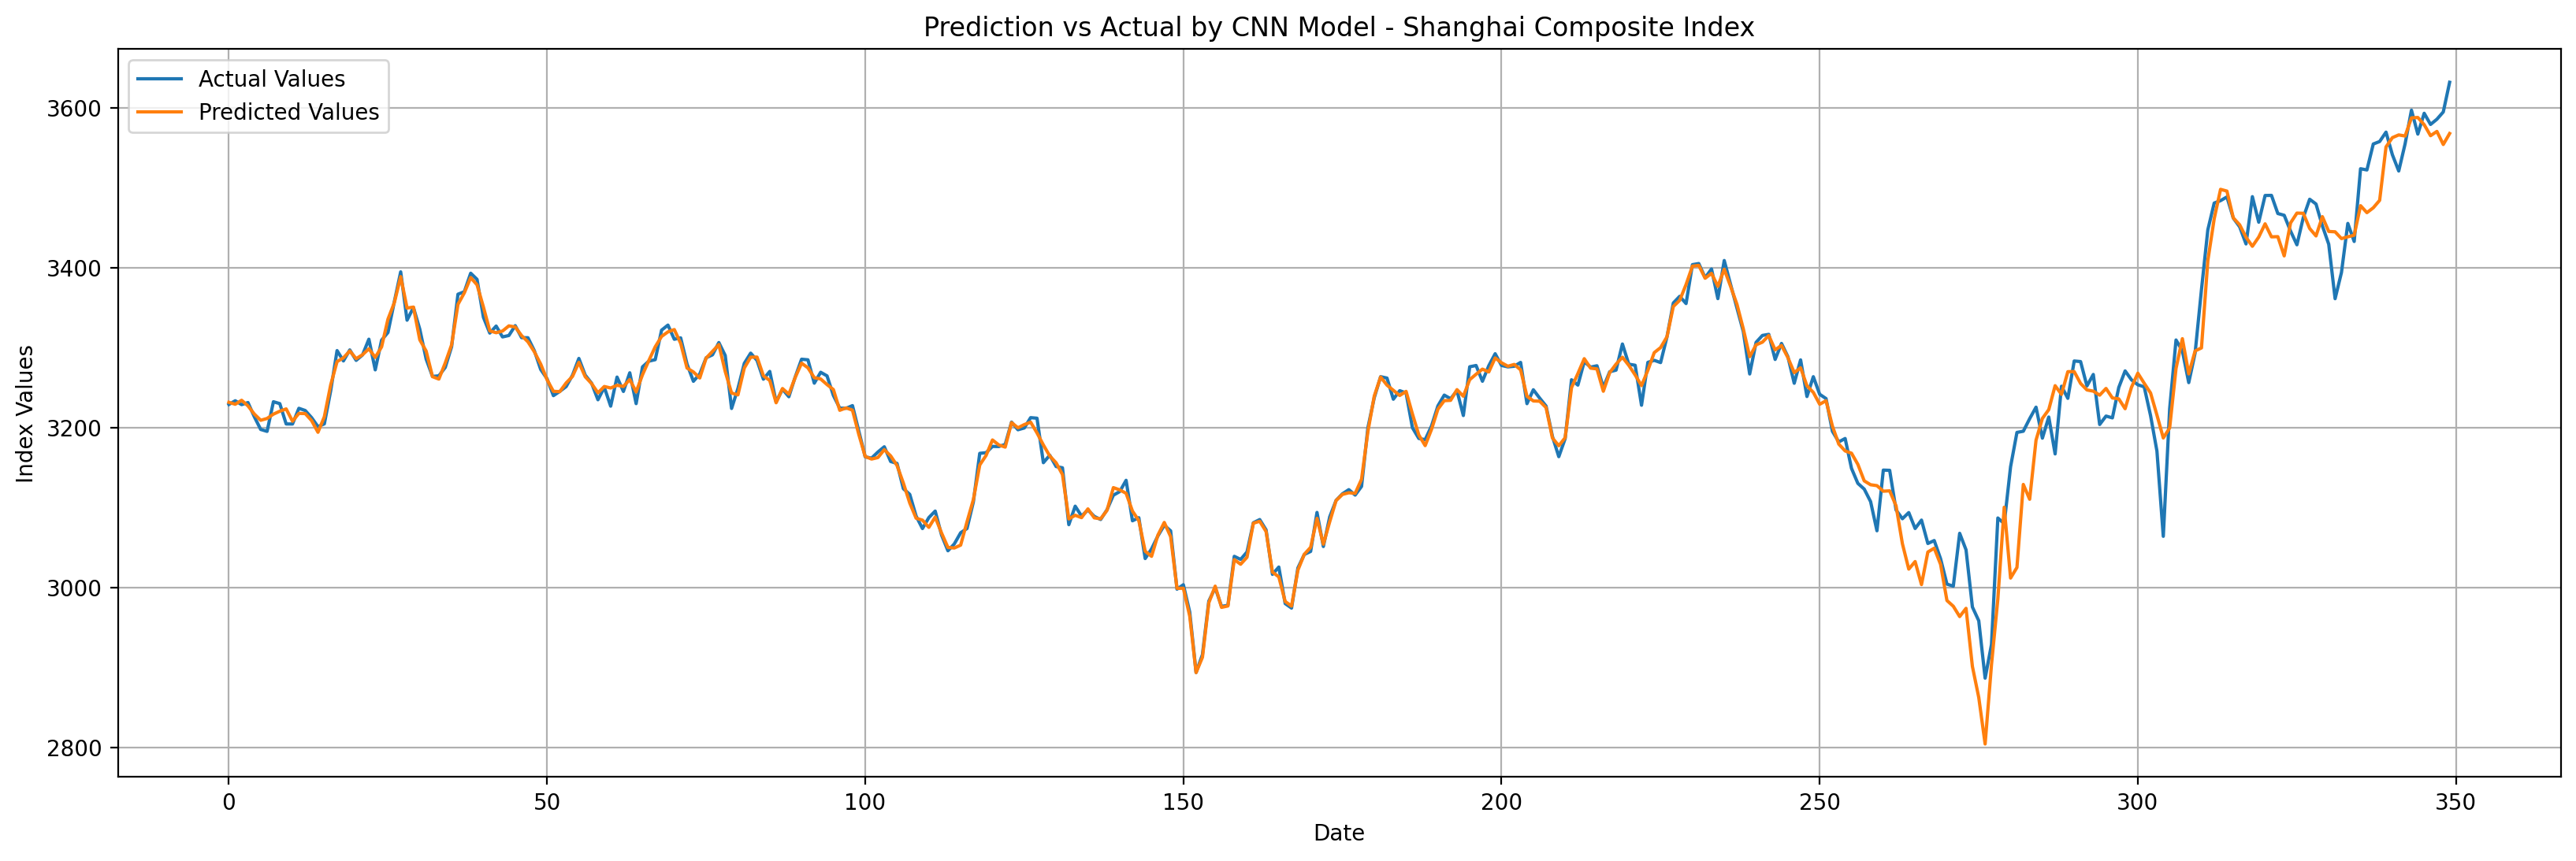

In [16]:
temp = pd.DataFrame(zip(prediction, actual_final), columns=["y_pred", "test"])
# 可视化预测结果和实际数据
plt.figure(figsize=(20, 6))
plt.plot(temp.index, temp["test"], label="Actual Values")
plt.plot(temp.index, temp["y_pred"], label="Predicted Values")
plt.xlabel("Date")
plt.ylabel("Index Values")
plt.title("Prediction vs Actual" + " by CNN Model - " + stock_name[stock_index])
plt.legend()
plt.grid()
plt.show()